In [1]:
!git clone https://github.com/shashankhalo7/era1.git

Cloning into 'era1'...
remote: Enumerating objects: 428, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 428 (delta 1), reused 6 (delta 0), pack-reused 420
Receiving objects: 100% (428/428), 209.09 MiB | 10.47 MiB/s, done.
Resolving deltas: 100% (100/100), done.
Updating files: 100% (398/398), done.


In [1]:
%cd era1/Session13/yolo_src

/content/era1/Session13/yolo_src


In [4]:
!cp /content/drive/MyDrive/era1/pascal-voc-dataset-used-in-yolov3-video.zip /content/
!unzip /content/pascal-voc-dataset-used-in-yolov3-video.zip

Streaming output truncated to the last 5000 lines.
  inflating: PASCAL_VOC/labels/2009_004289.txt  
  inflating: PASCAL_VOC/labels/2009_004290.txt  
  inflating: PASCAL_VOC/labels/2009_004291.txt  
  inflating: PASCAL_VOC/labels/2009_004295.txt  
  inflating: PASCAL_VOC/labels/2009_004298.txt  
  inflating: PASCAL_VOC/labels/2009_004300.txt  
  inflating: PASCAL_VOC/labels/2009_004301.txt  
  inflating: PASCAL_VOC/labels/2009_004303.txt  
  inflating: PASCAL_VOC/labels/2009_004307.txt  
  inflating: PASCAL_VOC/labels/2009_004308.txt  
  inflating: PASCAL_VOC/labels/2009_004309.txt  
  inflating: PASCAL_VOC/labels/2009_004312.txt  
  inflating: PASCAL_VOC/labels/2009_004315.txt  
  inflating: PASCAL_VOC/labels/2009_004316.txt  
  inflating: PASCAL_VOC/labels/2009_004317.txt  
  inflating: PASCAL_VOC/labels/2009_004319.txt  
  inflating: PASCAL_VOC/labels/2009_004322.txt  
  inflating: PASCAL_VOC/labels/2009_004323.txt  
  inflating: PASCAL_VOC/labels/2009_004324.txt  
  inflating: PASCA

In [11]:
!pip install -r ../../Session\ 12/app/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38245 sha256=c330b3fcec99d134f58f67641360353d7f1da807b922daa23f89eff634c08091
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [2]:
import config
import torch
import torch.optim as optim

from yolo_lt import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from loss import YoloLoss
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_loader, test_loader, train_eval_loader = get_loaders(
    train_csv_path=config.DATASET + "/train.csv", test_csv_path=config.DATASET + "/test.csv"
)

In [4]:
len(train_loader),len(test_loader),len(train_eval_loader)

(1035, 310, 1035)

In [5]:
model = YOLOv3(config,train_loader,test_loader,num_classes=config.NUM_CLASSES)

In [6]:
from torchsummary import summary
input_shape = (3,config.IMAGE_SIZE,config.IMAGE_SIZE)
summary(model,input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─CNNBlock: 2-1                     [-1, 32, 416, 416]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 416, 416]        864
|    |    └─BatchNorm2d: 3-2             [-1, 32, 416, 416]        64
|    |    └─LeakyReLU: 3-3               [-1, 32, 416, 416]        --
|    └─CNNBlock: 2-2                     [-1, 64, 208, 208]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 208, 208]        18,432
|    |    └─BatchNorm2d: 3-5             [-1, 64, 208, 208]        128
|    |    └─LeakyReLU: 3-6               [-1, 64, 208, 208]        --
|    └─ResidualBlock: 2-3                [-1, 64, 208, 208]        --
|    └─CNNBlock: 2-4                     [-1, 128, 104, 104]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 104, 104]       73,728
|    |    └─BatchNorm2d: 3-8             [-1, 128, 104, 104]       256
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─CNNBlock: 2-1                     [-1, 32, 416, 416]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 416, 416]        864
|    |    └─BatchNorm2d: 3-2             [-1, 32, 416, 416]        64
|    |    └─LeakyReLU: 3-3               [-1, 32, 416, 416]        --
|    └─CNNBlock: 2-2                     [-1, 64, 208, 208]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 208, 208]        18,432
|    |    └─BatchNorm2d: 3-5             [-1, 64, 208, 208]        128
|    |    └─LeakyReLU: 3-6               [-1, 64, 208, 208]        --
|    └─ResidualBlock: 2-3                [-1, 64, 208, 208]        --
|    └─CNNBlock: 2-4                     [-1, 128, 104, 104]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 104, 104]       73,728
|    |    └─BatchNorm2d: 3-8             [-1, 128, 104, 104]       256
|   

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | layers  | ModuleList | 61.6 M
1 | loss_fn | YoloLoss   | 0     
---------------------------------------
61.6 M    Trainable params
0         Non-tr

Training: 0it [00:00, ?it/s]

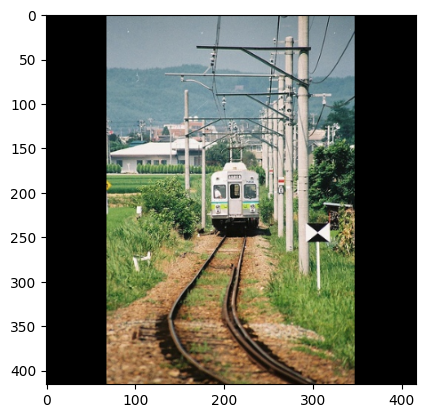

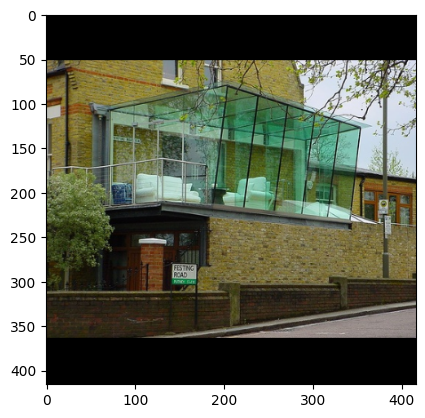

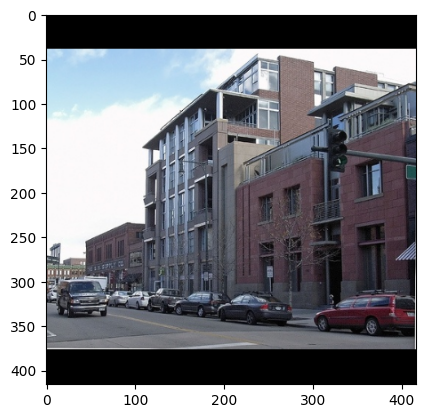

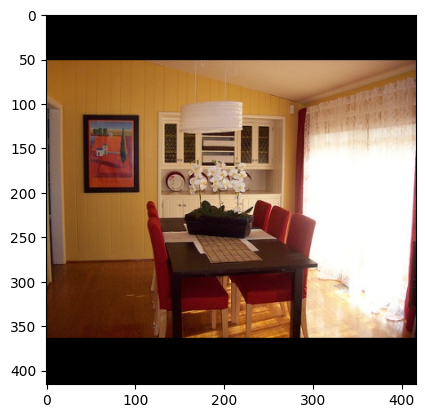

=> Saving checkpoint



100%|██████████| 1035/1035 [06:25<00:00,  2.69it/s]


Class accuracy is: 1.846434%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%



100%|██████████| 310/310 [01:16<00:00,  4.06it/s]


Class accuracy is: 1.493489%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%



  0%|          | 0/310 [00:00<?, ?it/s]

In [ ]:
import lightning.pytorch as pl

model = YOLOv3(config,train_loader,test_loader,num_classes=config.NUM_CLASSES)
trainer = pl.Trainer(accelerator="auto",precision=16,max_epochs = 40)
trainer.fit(model,train_loader,test_loader)